Train both MLP and LSTM on the first 79 timesteps of data and test on the others.

In [ ]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 13.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import *

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m25)}")


m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
m0 = np.delete(m0, (45,83,77),axis=0)
print(f"Before reshaping: {np.shape(m0)}")

# for each trach, each parameter, the first timestep data is just the index of the stations
m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#tar is SWH at coastline
tar = m0[:,:,:,2]
tar[np.isnan(tar)] = 0

# split the train and test by time
tar_train = tar[:,:79,:]
tar_test = tar[:,79:,:]

m25_train = m25[:,:79,:,:]
m25_test = m25[:,79:,:,:]

#further reshaping
tar_rs_train = np.reshape(tar_train, (np.shape(tar_train)[0]*np.shape(tar_train)[1],np.shape(tar_train)[2]))
print(f"After reshaping: {tar_rs_train.shape}")

tar_rs_test = np.reshape(tar_test, (np.shape(tar_test)[0]*np.shape(tar_test)[1],np.shape(tar_test)[2]))
print(f"After reshaping: {tar_rs_test.shape}")

feature25m_train = np.reshape(m25_train, (np.shape(m25_train)[0]*np.shape(m25_train)[1],np.shape(m25_train)[2],np.shape(m25_train)[3]))
print(f"After reshaping: {feature25m_train.shape}")

feature25m_test = np.reshape(m25_test, (np.shape(m25_test)[0]*np.shape(m25_test)[1],np.shape(m25_test)[2],np.shape(m25_test)[3]))
print(f"After reshaping: {feature25m_test.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
feature25m_train = convert_deg_to_sin_cos(feature25m_train)
print(feature25m_train.shape)

feature25m_test = convert_deg_to_sin_cos(feature25m_test)
print(feature25m_test.shape)

#further reshape
feature25m_train = feature25m_train.reshape(feature25m_train.shape[0],feature25m_train.shape[1]*feature25m_train.shape[2])
print(feature25m_train.shape)

feature25m_test = feature25m_test.reshape(feature25m_test.shape[0],feature25m_test.shape[1]*feature25m_test.shape[2])
print(feature25m_test.shape)

mean25m_train,std25m_train,feature25_train = normalize(feature25m_train)
mean25m_test,std25m_test,feature25_test = normalize(feature25m_test)
# mean0m,std0m,tar_rs = normalize(tar_rs)  #as in the paper James 2018, no normalization to the target

Before reshaping: (185, 98, 155, 6)
Before reshaping: (185, 98, 145, 6)
After reshaping: (14615, 145)
After reshaping: (3330, 145)
After reshaping: (14615, 155, 6)
After reshaping: (3330, 155, 6)
(14615, 155, 8)
(3330, 155, 8)
(14615, 1240)
(3330, 1240)


In [ ]:
#train MLP

seed = 42
lr = 1e-4
# momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 500
weight_decay = 0.0001

In [ ]:
traindata = MLPDataset(feature25m_train,tar_rs_train)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
valdata = MLPDataset(feature25m_test,tar_rs_test)

In [ ]:
# instantiation
model = simpleFFN().to(device)
criterion = nn.MSELoss()

In [ ]:
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
validation_loader = DataLoader(valdata, batch_size=test_batch_size, shuffle=False, num_workers=0)
# test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

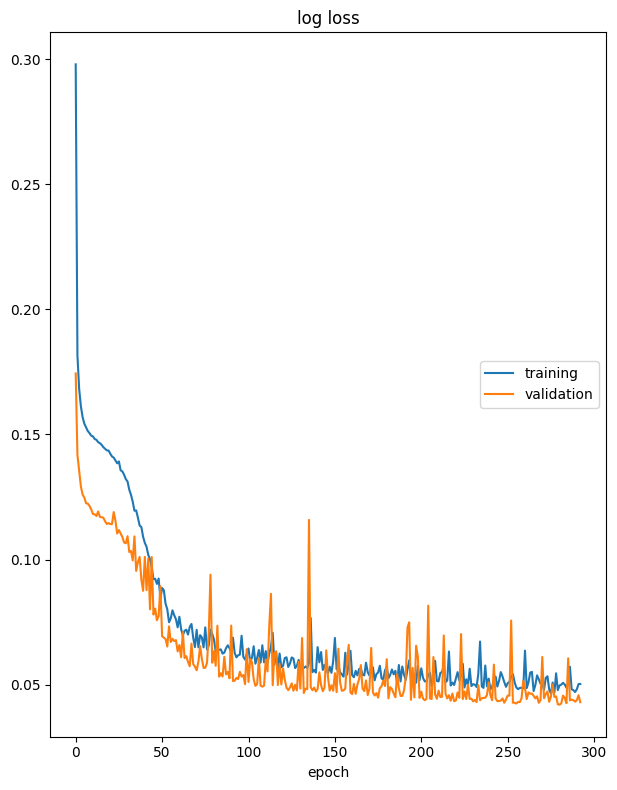

log loss
	training         	 (min:    0.046, max:    0.298, cur:    0.050)
	validation       	 (min:    0.042, max:    0.174, cur:    0.043)
0.04300221428275108


KeyboardInterrupt: ignored

In [ ]:
# built in lr (e-4)
optimizer = torch.optim.Adam(model.parameters(),lr = lr,weight_decay=weight_decay)
liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(n_epochs):
    logs = {}
    train_loss= torch.sqrt(mlptrain(model, optimizer, criterion, train_loader,device = device))

    logs['' + 'log loss'] = train_loss.item()
    # logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss= torch.sqrt(mlpvalidate(model, criterion, validation_loader,device=device))
    logs['val_' + 'log loss'] = validation_loss.item()
    # logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

In [ ]:
torch.save(model, '/content/drive/MyDrive/IRP/model/MLP25m20pertimeunseen.npy')

In [ ]:
# train LSTM
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 1240
output_size = 145

n_hidden = 64
n_layers = 2
batch_size = 256
sequence_length = 9

lr = 3e-4
weight_decay = 0.0001

n_epochs = 500


traindata = lstmDataset(feature25m_train,tar_rs_train,sequence_length=sequence_length,intervel=79)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
valdata = lstmDataset(feature25m_test,tar_rs_test,sequence_length=sequence_length,intervel=18)

train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(valdata, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)


lstm_gen = LSTM_GEN(input_size, output_size, n_hidden, n_layers,device=device).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

# test shape
a, b = next(iter(train_loader))
print(a.shape,b.shape)
lstm_gen = lstm_gen.to(device)
lstm_gen.double()
a = a.to(device)
print(lstm_gen(a).shape)

The model has 376,017 trainable parameters
torch.Size([256, 9, 1240]) torch.Size([256, 9, 145])
torch.Size([256, 9, 145])


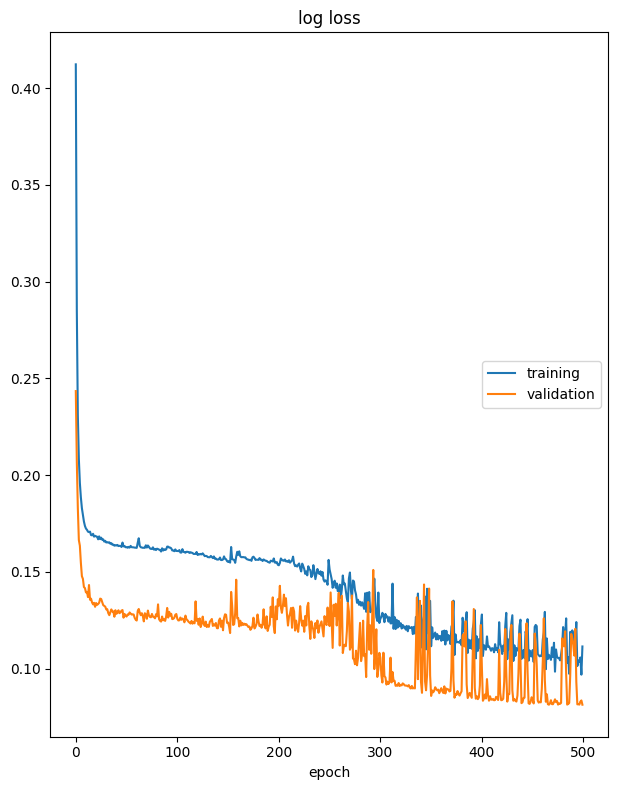

100%|██████████| 500/500 [19:20<00:00,  2.32s/it]

log loss
	training         	 (min:    0.097, max:    0.412, cur:    0.112)
	validation       	 (min:    0.081, max:    0.243, cur:    0.081)


In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr,weight_decay = weight_decay)

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in tqdm(range(n_epochs)):
    logs = {}
    # print(criterion)
    train_loss = torch.sqrt(train_lstm_gen(lstm_gen, optimizer, criterion, train_loader,device=device))
    val_loss = torch.sqrt(val_lstm_gen(lstm_gen, criterion, validation_loader,device=device))
    # print('1')

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = val_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    ## save a model every 5 epochs
    # if (epoch > 5) and ( (epoch+1) % 5) == 0:
    #   torch.save(lstm_gen.state_dict(), f'/content/gdrive/MyDrive/BigData/assessment/modelpca_{epoch+1}_3_5')

In [ ]:
torch.save(lstm_gen, '/content/drive/MyDrive/IRP/model/LSTM25m20pertimeunseen.npy')

Test the two models on the testset.

In [ ]:
mlp = torch.load('/content/drive/MyDrive/IRP/model/MLP25m20pertimeunseen.npy')

res = mlp(torch.tensor(feature25m_test).float().to(device))
res = res.cpu().detach().numpy()

res = res.flatten()
tar = tar_rs_test.flatten()

calculate_metrics(tar, res)

{'Bias': -0.022100161984206498,
 'RMSE': 0.10635130491478292,
 'Scatter Index': 0.8674605096796673,
 'Correlation Coefficient': 0.9434810181239034,
 'Coefficient of Efficiency': 0.8812575909548127,
 'Index of Agreement': 0.9697758957462429,
 'MAE': 0.0418342375702772}

In [ ]:
lstm = torch.load('/content/drive/MyDrive/IRP/model/LSTM25m_structured.npy')
data = lstmDataset(feature25m_test,tar_rs_test,sequence_length=9,intervel=18)
dataloader = DataLoader(data, batch_size=len(data), shuffle=False)
allfeature, alltar = next(iter(dataloader))
allres = lstm(allfeature.to(device))

alltar = alltar[:,-1,:].cpu().detach().numpy().flatten()
allres = allres[:,-1,:].cpu().detach().numpy().flatten()

calculate_metrics(alltar, allres)

{'Bias': 0.3915027306257615,
 'RMSE': 0.5948502065359486,
 'Scatter Index': 5.271779788273246,
 'Correlation Coefficient': 0.6475755090322952,
 'Coefficient of Efficiency': -3.299813730170099,
 'Index of Agreement': 0.5887523383034929,
 'MAE': 0.3988887955593545}